In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import mlflow
import os

os.chdir('../../')

def md(s : str):
    display(Markdown(s))

def count_and_percent(df: pd.DataFrame, col : str):
    qc = pd.DataFrame(df[col].value_counts()).sort_index().rename({col:'Count'}, axis=1)
    qcn = (qc / len(df) * 100).rename({'Count':'Percent of Total'}, axis=1)
    return pd.concat([qc, qcn], axis=1)

### Load Data
df = pd.read_pickle('data/interim/masterdbForNLPSpacyProc.pkl')
train = pd.read_pickle('data/processed/train.pkl')
test = pd.read_pickle('data/processed/test.pkl')


## QuAL Score
As a review, the QuAL score aims to assess the quality of written feedback for medical trainees. It has been validated in a GME context. It ranges from 0 (lowest quality) to 6 (highest quality). It is the sum of three subscores:

* Q1 - Does the rater provide sufficient evidence about resident performance? (Rated on a three-point scale: 0-no comment at all, 1-no, but comment present, 2-somewhat, 3-yes/full description)
* Q2 - Suggestion - Does the rater provide a suggestion for improvement? (0-no/1-yes)
* Q3 - Connection - Is the rater’s suggestion linked to the behavior described? (0-no/1-yes)

## Data Descriptives and Demographics

In [2]:
#| echo: false
md(f"""
We analyzed {len(df)} evaluations, with {len(df[df['dataSource'] == 'Mac'])} from Site 1 (McMaster) and {len(df[df['dataSource'] == 'Sas'])} from Site 2 (Saskatchewan). 
""")


We analyzed 2500 evaluations, with 1250 from Site 1 (McMaster) and 1250 from Site 2 (Saskatchewan). 


For each evaluation, the QuAL score was rated by two separate raters. Each sub-score (Q1, Q2, and Q3) was rated and then summed to get the final QuAL score. Discrepancies were broken by members of the study team (who?) 

In [3]:
md(f"""The average QuAL score was {df['QUAL'].mean()}, with standard deviation 
{df['QUAL'].std():.3f}, median {df['QUAL'].median()}""")

The average QuAL score was 2.6408, with standard deviation 
1.275, median 3.0

Descriptive statistics for the subscores and QuAL Score were:

In [4]:
cols = ['Q1','Q2','Q3','QUAL']
df[cols].describe().loc[['count','mean','std','50%'],:]

,Q1,Q2,Q3,QUAL
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,2.277200,0.193600,0.170000,2.640800
std,0.860149,0.395198,0.375708,1.275157
50%,3.000000,0.000000,0.000000,3.000000


### Score Distributions
#### Subscores

In [5]:
pd.concat({
    'Q1':count_and_percent(df, 'Q1'),
    'Q2':count_and_percent(df, 'Q2'),
    'Q3':count_and_percent(df, 'Q3')
}, axis=1)

Q1                       Q2                       Q3                 
  Count Percent of Total   Count Percent of Total   Count Percent of Total
0   105             4.20  2016.0            80.64  2075.0             83.0
1   359            14.36   484.0            19.36   425.0             17.0
2   774            30.96     NaN              NaN     NaN              NaN
3  1262            50.48     NaN              NaN     NaN              NaN

The distribution for the subscores is plotted below:

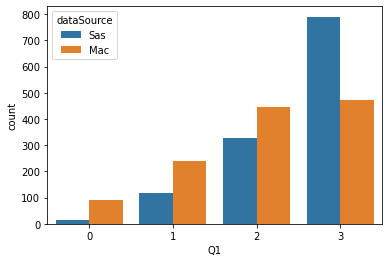

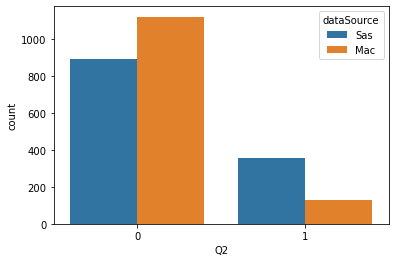

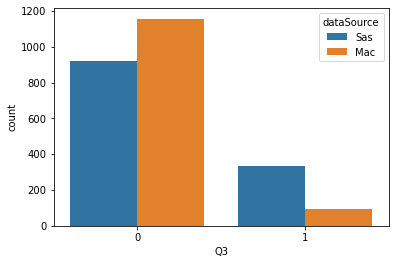

In [6]:
#| layout-ncol: 3
#| fig-cap: Distribution of QuAL Subscores
#| fig-subcap: 
#|  - "Q1"
#|  - "Q2"
#|  - "Q3"
f = sns.countplot(x='Q1', hue='dataSource', data=df)
plt.show(f)
f2 = sns.countplot(x='Q2', hue='dataSource', data=df)
plt.show(f2)
f3 = sns.countplot(x='Q3', hue='dataSource', data=df)
plt.show(f3)

Evaluations tended to score highly (> 2) on Q1, but poorly (80% 0 and 83% 0, respectively) on Q2 and Q3. There were large differences in scores between the two sites.

#### QuAL Score
The table below shows the raw counts and percentages associated with each level of the rated QuAL score.

In [7]:
count_and_percent(df, 'QUAL')

,Count,Percent of Total
0,100,4.00
1,338,13.52
2,685,27.40
3,957,38.28
4,77,3.08
5,343,13.72


The distribution of the QuAL score is plotted below:

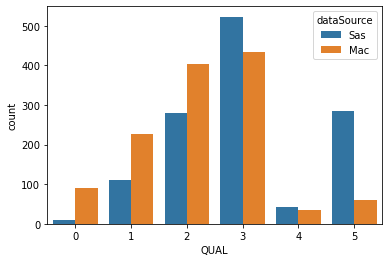

In [8]:
plt.show(sns.countplot(x='QUAL', hue='dataSource', data=df))

This table shows the counts/frequencies for each possible combination of subscores. For each possible final QuAL score, the table shows the combination fo subscores most likely to generate that QuAL score.

In [9]:
vc = df[cols].value_counts(normalize=False)
vc = pd.DataFrame(vc).reset_index()
vc = vc.set_index(['QUAL','Q1','Q2','Q3'])
vc = vc.sort_index().rename({0:'Count'}, axis=1)
vc = pd.concat([vc, (vc / 2500 * 100).rename({'Count':'Percent of Total'}, axis=1)], axis=1)
vc

Count  Percent of Total
QUAL Q1 Q2 Q3                         
0    0  0  0     100              4.00
1    0  1  0       5              0.20
     1  0  0     333             13.32
2    1  0  1       1              0.04
        1  0      21              0.84
     2  0  0     663             26.52
3    1  1  1       4              0.16
     2  0  1       2              0.08
        1  0      41              1.64
     3  0  0     910             36.40
4    2  1  1      68              2.72
     3  0  1       7              0.28
        1  0       2              0.08
5    3  1  1     343             13.72

This table yields some interesting insights. The QuAL score subscores are dependent on one another. Based on the structure of the subscores, it follows that if the evaluation is not detailed enough (Q1 $\leq$ 2), it's unlikely to contain a suggestion for improvement (Q1 = 0), and there can be no linking between behavior and improvement (Q3 = 0). The table backs this up, with the vast majority of Q2 and Q3 rated as zero if Q1 $\leq$ 2. If the evaluation is highly detailed (Q3 = 3), then naturally it is more likely to have a suggestion for improvement (Q2 = 1), and based on the table, it's also likely to link the suggestion to the behavior (Q3 = 1). Q3 is essentially redundant; Q3 is discrepant from Q3 in only 3.1% of all evaluations. 

This means that the QuAL score can be reduced to three primary outcomes:

* Q1 $\leq$ 2 - low detail, very unlikely (<10%) to contain suggestion for improvement 
* Q1 = 3; Q2 and Q3 = 0 - high detail,  no suggestion for improvement
* Q1 = 3; Q2 and Q3 = 1 - high detail, with suggestion for improvement, extremely likely to have connection between behavior/suggestion

These three scenarios fit 2,349/2,500 = 94% of evaluations. This provides an opportunity to condense the QuAL score from 6 levels (0-5) to 3. Although the remainder of the results below do *not* condense the QuAL score, this could be a good way to boost accuracy results in a way that does not compromise the integrity of the score itself. 

### Interrater Reliability
This table shows the percent agreement for the QUAL score and each subscore

In [10]:
pd.concat({
    'Q1Match' : count_and_percent(df, 'Q1Match'),
    'Q2Match' : count_and_percent(df, 'Q2Match'),
    'Q3Match' : count_and_percent(df, 'Q3Match'),
    'QUALMatch' : count_and_percent(df, 'perfectMatch')
}, axis=1)

Q1Match                  Q2Match                  Q3Match  \
        Count Percent of Total   Count Percent of Total   Count   
False    1059            42.36     188             7.52     606   
True     1441            57.64    2312            92.48    1894   

                       QUALMatch                   
      Percent of Total     Count Percent of Total  
False            24.24      1426            57.04  
True             75.76      1074            42.96

In [11]:
from sklearn.metrics import cohen_kappa_score
pd.DataFrame(pd.Series([
    cohen_kappa_score(df['q1p1'], df['q1p2']),
    cohen_kappa_score(df['q2p1'], df['q2p2']),
    cohen_kappa_score(df['q3p1'], df['q3p2']),
    cohen_kappa_score(df['P1QualScore'], df['P2QualScore'])
], index=['Q1','Q2','Q3','QuAL']), columns=['Cohen\'s Kappa'])

,Cohen's Kappa
Q1,0.387601
Q2,0.751249
Q3,0.351520
QuAL,0.317628


Cohen's Kappas were calculated and are presented above. There was fair agreement for all scores except for Q1, which had substantial agreement. This was before any tiebreaking/discrepancy correction. 

### Other Demographics and Descriptive Statistics
These may or may not be relevant. 

In [12]:
pd.concat({
    c : count_and_percent(df, c)
    for c in ['GenderRes','GenderFac']
}, axis=1)

GenderRes                  GenderFac                 
            Count Percent of Total     Count Percent of Total
Female     1037.0            41.48       877            35.08
Male       1463.0            58.52      1447            57.88
Unknown       NaN              NaN       176             7.04

ObserverType stratifies the evaluator by role.

In [13]:
pd.concat({
    c : count_and_percent(df, c)
    for c in ['ObserverType']
}, axis=1)

ObserverType                 
                           Count Percent of Total
clinical supervisor         1200             48.0
faculty                     1165             46.6
resident                     135              5.4

Only one of the two sites reports PGY levels for their trainees on their evaluations.

In [14]:
pd.DataFrame(df['PGY'].value_counts())

,PGY
Unknown,1251
2,510
1,456
3,157
4,117
5,9


## Model Performance
### Metrics
Models were assessed using the following performance metrics:

* *Balanced Accuracy* - The weighted average of accuracies for each possible class (rating). In situations where the data is imbalanced, including this one, accuracy can be falsely inflated if the model over-biases against the rare classes. Balanced accuracy compensates for this and provides a more valid assessment of model performance in the real world. It is the most important metric evaluated.
* *Accuracy* - The percentage of time the model made the correct guess about the rating
* *Top 2 Accuracy* - The percentage of time the model's first guess **or** second guess was correct. Only applies to targets with $\geq$ 2 levels (Q1 and overall QuAL)
* *Top 3 Accuracy* - Same as above but includes first, second, or third guess.
* *Mean absolute error (MAE)* - Average discrepancy between the model's guess and the true rating. Useful for Q1 and QuAL.
* *ROC AUC Score* - Area under the receiver operating curve. Common metric reported in ML literature. Subject to inflation if classes are imbalanced. Only well-defined for two-class targets (Q2 and Q3).
* *Precision* - Positive predictive value, the chance that a "positive" prediction (usually defined as the outcome of interest, in this case **lower** quality) is actually correct. Best defined for two-class targets, but averages can be taken for multi-class targets (Q1 and QuAL).
* *Recall* - Sensitivity
* *F1* - The geometric mean of precision and recall, often reported in the ML literature.

### Q1
Q1 assessed the level of evidence about the learner's performance provided in the evaluation.
Specifically, Q1 asked, "Does the rater provide sufficient evidence about resident performance?" It was rated on a three-point scale: 0-no comment at all, 1-no, but comment present, 2-somewhat, 3-yes/full description.

In [23]:
moi = ['balanced_accuracy','accuracy','precision','recall','f1','roc_auc']
def eval_model_performance(run_id: str, moi):
    run = mlflow.get_run(run_id)
    mets = run.data.metrics
    return pd.DataFrame(pd.Series(mets)).rename({0:'Score'}, axis=1)

The table below shows the model performance metrics for Q1.

In [30]:
RUN_ID = 'abfc70ff15504cf5993250071cfb566e'
moi = ['balanced_accuracy','accuracy','top_2_acc','top_3_acc','precision','recall','f1']
eval_model_performance(RUN_ID, moi).loc[moi,:]

,Score
balanced_accuracy,0.590736
accuracy,0.624000
top_2_acc,0.880000
top_3_acc,0.973333
precision,0.620417
recall,0.590736
f1,0.598159


Overall, model performance for Q1 is relatively weak when considered from an absolute accuracy standpoint, getting on average 59% of predictions correct. However, as Q1 has four possible ratings (0-3), random guessing would be correct only 25% of the time, so our model performs 2.36 times better than random. Looking at the Top 2 Accuracy, we see the model contains the true rating within its top-2 predictions 88% of the time, which further demonstrates that the model is "on the right track." 

Exploring performance by class level, we can begin to see the reasons for high/low performance:

In [35]:
RUN_ID = 'abfc70ff15504cf5993250071cfb566e'
moi = ['f1_0','f1_1','f1_2','f1_3']
pd.concat([
    eval_model_performance(RUN_ID, moi).loc[moi,:].reset_index().rename({'Score':'F1 Score'}, axis=1),
    eval_model_performance(RUN_ID, moi).loc[['supp_0','supp_1','supp_2','supp_3'], :].reset_index().rename({'Score':'Support'}, axis=1)
], axis=1)

,index,F1 Score,index,Support
0,f1_0,0.727273,supp_0,25.0
1,f1_1,0.400000,supp_1,49.0
2,f1_2,0.500000,supp_2,113.0
3,f1_3,0.765363,supp_3,188.0
